# Classify Movie Reviews
### Dan Finkel
### September 7 2018
Classifier that labels movies for genre

This notebook is a variant on v1 in that a genre
is chosen and classifier classifies against the field (instead of against another genre)

In [2]:
# standard imports
import numpy as np
import pandas as pd
import cPickle
from collections import defaultdict
import re
import sys
import os
import glob
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime

# keras imports
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding, Dropout
from keras.layers import Dense, Input, Flatten, ZeroPadding1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, merge, Dropout, Activation
from keras.models import Model, Sequential

from keras.engine import Layer, InputSpec
import tensorflow as tf

# sklearn imports
from sklearn import metrics
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cross_validation import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

# allows for inline plotting
%matplotlib inline

# pretty plots
plt.style.use("bmh")

# Globals
MAX_SEQUENCE_LENGTH = 300
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Stage Training and Test Data

In [3]:
"""Pull review data"""

def get_reviews(labels_fname, dirpath):
    """
    pull movie reviews from txt files into frame
        labels_fname - flags if training or test data
        dirpath - path the datafiles
    """

    # read data
    df_neg = pd.read_csv(labels_fname + '_neg_genres.csv', encoding='utf-8')
    df_pos = pd.read_csv(labels_fname + '_pos_genres.csv', encoding='utf-8')
       
    # get the review filenames
    def get_fname(search_string):
        return glob.glob(search_string)[0].split('/')[-1]

    neg_dirpath = dirpath + "neg/"
    neg_fnames = [get_fname(neg_dirpath + str(ii) + '_*.txt') for ii in df_neg['ref'].values]

    pos_dirpath = dirpath + "pos/"
    pos_fnames = [get_fname(pos_dirpath + str(ii) + '_*.txt') for ii in df_pos['ref'].values]

    # pull the text of the reviews
    def get_reviews(dirpath, fnames):
        reviews = []
        for fname in fnames:
            with open(dirpath + fname, 'r') as myfile:
                data=myfile.read()
            reviews.append(data)
        return reviews

    neg_reviews = get_reviews(neg_dirpath, neg_fnames)
    pos_reviews = get_reviews(pos_dirpath, pos_fnames)
    
    df_neg['text'] = neg_reviews
    df_pos['text'] = pos_reviews
    df_out = pd.concat([df_neg, df_pos])

    return df_out

In [4]:
df_train = get_reviews("stanford_train",
                             "/Users/dfinkel/Downloads/aclImdb/train/")
                             #"/Users/danfinkel/git_base/python/text_classification/stanford_data/aclImdb/train/",

# shuffle rows
df_train = df_train.sample(frac=1).reset_index(drop=True)

# Drop duplicate reviews
print len(df_train)
df_train = df_train.drop_duplicates('text')
print len(df_train)


24949
24853


In [5]:
df_test = get_reviews("stanford_test",
                             "/Users/dfinkel/Downloads/aclImdb/test/")
                             #"/Users/danfinkel/git_base/python/text_classification/stanford_data/aclImdb/train/",
print len(df_test)
df_test = df_test.drop_duplicates('text')
print len(df_test)

24929
24730


In [8]:
# Define class
GENRE = 'Action'

# create labels
df_train['class'] = 1 - df_train[GENRE].values
df_train.head()
print df_train[GENRE].sum(), len(df_train) - df_train[GENRE].sum()

df_test_genre = df_test.loc[df_test[GENRE] == 1]
df_test_not_genre = df_test.loc[df_test[GENRE] == 0]
print len(df_test_genre), len(df_test_not_genre)

 4414 20439
4302 20428


In [9]:
def word_count(text):
    return len(text.split(' '))

df_train['wordcount'] = df_train['text'].apply(word_count)

## Prep for Classification (Keras / TensorFlow DCNN)

In [10]:
"""
Tokenize the comments and 
convert to numerical sequences
"""

# Tokenize comments
texts = df_train['text'].values

# Initialize tokenizer
# nb_words tells tokenizer to only keep MAX_NB_WORDS
# when texts_to_sequences is applied
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)

# encoding text tokens to sequences
tokenizer.fit_on_texts(texts)

# convert text to numerical arrays
sequences = tokenizer.texts_to_sequences(texts)

# count unique tokens in corpus
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/usr/local/lib/python2.7/site-packages/keras/preprocessing/text.py:172: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 88492 unique tokens.


In [11]:
"""
Bookkeeping
"""
# convert comment labels to categorical tensor
labels = df_train['class']
labels = to_categorical(np.asarray(labels))

# zero-pad comments
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

('Shape of data tensor:', (24853, 300))
('Shape of label tensor:', (24853, 2))


In [12]:
# randomly sort data into train/test sets
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('Number of positive and negative reviews in traing and validation set ')
print y_train.sum(axis=0)
print y_val.sum(axis=0)

Number of positive and negative reviews in traing and validation set 
[ 3550. 16333.]
[ 864. 4106.]


In [13]:
# import GLOVE word embeddings
# see: https://nlp.stanford.edu/projects/glove/
# GLOVE_DIR = "/Users/danfinkel/datasets/glove/"
GLOVE_DIR = "/Users/dfinkel/proto_dev/data_science/glove_data/glove_files/"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Total %s word vectors in Glove 840B 300d.' % len(embeddings_index))


# Create embedding layer 
# using glove data

# embedding matrix maps words onto vectors
# initialize with uniform random numbers (?)
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index 
        # will be uniform random numbers
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

Total 400000 word vectors in Glove 840B 300d.


## Build and Train DCNN 
Use model from https://arxiv.org/pdf/1404.2188.pdf

In [14]:
class KMaxPooling(Layer):
    """
    K-max pooling layer that extracts the k-highest activations from a sequence (2nd dimension).
    TensorFlow backend.
    """
    def __init__(self, k=1, axis=1, **kwargs):
        super(KMaxPooling, self).__init__(**kwargs)
        self.input_spec = InputSpec(ndim=3)
        self.k = k

        assert axis in [1,2],  'expected dimensions (samples, filters, convolved_values),\
                   cannot fold along samples dimension or axis not in list [1,2]'
        self.axis = axis

        # need to switch the axis with the last elemnet
        # to perform transpose for tok k elements since top_k works in last axis
        self.transpose_perm = [0,1,2] #default
        self.transpose_perm[self.axis] = 2
        self.transpose_perm[2] = self.axis

    def compute_output_shape(self, input_shape):
        input_shape_list = list(input_shape)
        input_shape_list[self.axis] = self.k
        return tuple(input_shape_list)

    def call(self, x):
        # swap sequence dimension to get top k elements along axis=1
        transposed_for_topk = tf.transpose(x, perm=self.transpose_perm)

        # extract top_k, returns two tensors [values, indices]
        top_k = tf.nn.top_k(transposed_for_topk, k=self.k, sorted=True, name=None)[0]

        # return back to normal dimension but now sequence dimension has only k elements
        # performing another transpose will get the tensor back to its original shape
        # but will have k as its axis_1 size
        transposed_back = tf.transpose(top_k, perm=self.transpose_perm)

        return transposed_back


class Folding(Layer):

    def __init__(self, **kwargs):
        super(Folding, self).__init__(**kwargs)
        self.input_spec = InputSpec(ndim=3)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], int(input_shape[2]/2))

    def call(self, x):
        input_shape = x.get_shape().as_list()

        # split the tensor along dimension 2 into dimension_axis_size/2
        # which will give us 2 tensors
        splits = tf.split(x, num_or_size_splits=int(input_shape[2]/2), axis=2)

        # reduce sums of the pair of rows we have split onto
        reduce_sums = [tf.reduce_sum(split, axis=2) for split in splits]

        # stack them up along the same axis we have reduced
        row_reduced = tf.stack(reduce_sums, axis=2)
        return row_reduced

In [15]:
"""
model based on: https://arxiv.org/pdf/1404.2188.pdf
"""

# Initialize model
model_1 = Sequential()

# Add an embedding layer
model_1.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True))

# zero bad 49 zeros to 
# both sides of comment
model_1.add(ZeroPadding1D((49,49)))

# 1D convolution
# 64 channels in output
# 50 values in convolution window
# zero pad output to perserve size
model_1.add(Conv1D(64, 50, padding="same"))

# Kmax pool
# Return k max values
# perserve order
model_1.add(KMaxPooling(k=5, axis=1))

# Activate w relu
model_1.add(Activation("relu"))

# zero pad 24 zeros to
# both sides of representation
model_1.add(ZeroPadding1D((24,24)))

# 1D convolution
# 64 channels in output
# 25 values in convolution window
# zero pad output to perserve size
model_1.add(Conv1D(64, 25, padding="same"))

# Fold output
#   - sum 2 channels together
#   - halves the channels
model_1.add(Folding())

# Kmax pool
# Return k max values
# perserve order
model_1.add(KMaxPooling(k=5, axis=1))

# Activate w relu
model_1.add(Activation("relu"))

# Flatten the data
model_1.add(Flatten())

# Connect the neural net
model_1.add(Dense(2, activation="softmax"))

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          26547900  
_________________________________________________________________
zero_padding1d_1 (ZeroPaddin (None, 398, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 64)           960064    
_________________________________________________________________
k_max_pooling_1 (KMaxPooling (None, 5, 64)             0         
_________________________________________________________________
activation_1 (Activation)    (None, 5, 64)             0         
_________________________________________________________________
zero_padding1d_2 (ZeroPaddin (None, 53, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 53, 64)            102464    
__________

In [16]:
model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model_1.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=4, batch_size=256)

/usr/local/lib/python2.7/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 19883 samples, validate on 4970 samples
Epoch 1/4
19883/19883 [==============================] - 657s 33ms/step - loss: 1.5015 - acc: 0.7913 - val_loss: 0.4497 - val_acc: 0.8262
Epoch 2/4
19883/19883 [==============================] - 665s 33ms/step - loss: 0.4243 - acc: 0.8251 - val_loss: 0.3762 - val_acc: 0.8461
Epoch 3/4
19883/19883 [==============================] - 699s 35ms/step - loss: 0.2868 - acc: 0.8815 - val_loss: 0.3166 - val_acc: 0.8660
Epoch 4/4
19883/19883 [==============================] - 668s 34ms/step - loss: 0.1464 - acc: 0.9443 - val_loss: 0.4229 - val_acc: 0.8165


### Validate Classifier Performance
DCNN

In [17]:
# convert text to numerical arrays
sequences = tokenizer.texts_to_sequences(df_test_genre['text'])

# zero-pad comments
genre_test_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', genre_test_data.shape)

genre_probs = model_1.predict_proba(genre_test_data)

('Shape of data tensor:', (4302, 300))


In [18]:
# convert text to numerical arrays
sequences = tokenizer.texts_to_sequences(df_test_not_genre['text'])

# zero-pad comments
not_genre_test_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', not_genre_test_data.shape)

not_genre_probs = model_1.predict_proba(not_genre_test_data)

('Shape of data tensor:', (20428, 300))


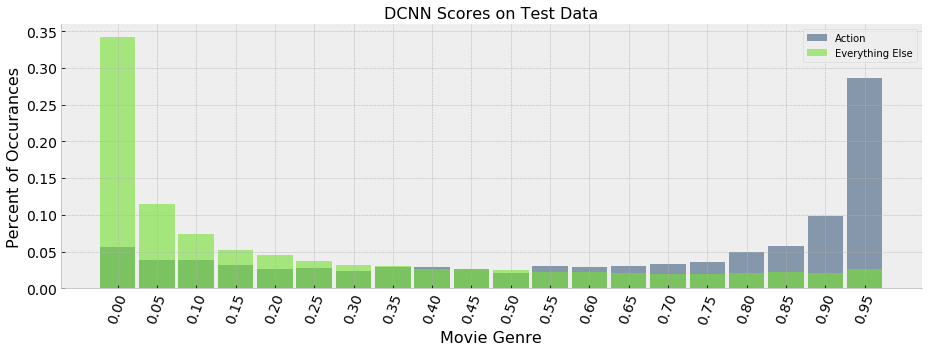

In [19]:
plt.figure(figsize=(13, 5))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

plt.xticks(np.arange(0, 1, .05), fontsize=14, rotation = 70)  
plt.yticks(fontsize=14)

plt.xlabel("Movie Genre", fontsize=16)  
plt.ylabel("Percent of Occurances", fontsize=16)
plt.title('DCNN Scores on Test Data', fontsize=16)

bins = np.arange(0, 1.05, 0.05)
h_drama, be = np.histogram([d[0] for d in genre_probs], bins)
h_comedy, be = np.histogram([d[0] for d in not_genre_probs], bins)
plt.bar(be[:-1], 1.0 * h_drama / np.sum(h_drama), width=0.045, facecolor = "#3F5D7D", alpha=0.6 )
plt.bar(be[:-1], 1.0 * h_comedy / np.sum(h_comedy), width=0.045, facecolor = "#74e22f", alpha=0.6 )
plt.legend(['Action', 'Everything Else'])
plt.tight_layout()
# plt.savefig('/Users/danfinkel/git_base/python/my_site/assets/images/histogram_drama_comedy_dcnn.png')

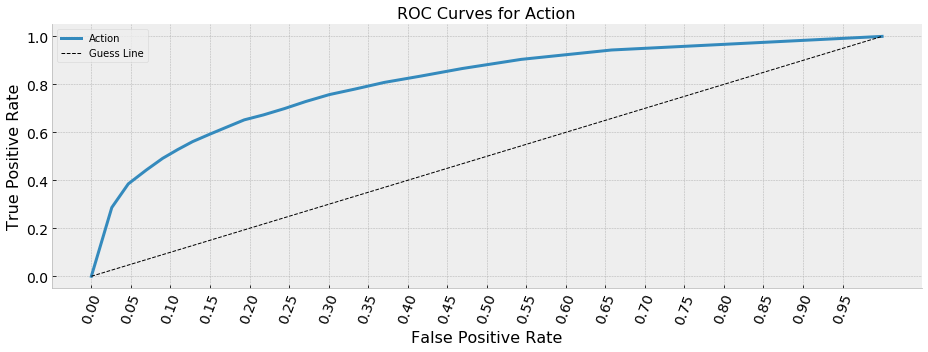

In [20]:
def roc_values(p1, p2):
    """
    compute true positive
    and false positive values
    relative to p1 and p2 vectors
    """
    tp = []
    fp = []
    for tt in np.arange(0, 1.05, 0.05):
        # tt is the threshold
        tp.append(1.0 * len([p for p in p1 if p[0] >= tt]) / len(p1))
        fp.append(1.0 * len([p for p in p2 if p[0] >= tt]) / len(p2))
        
    return tp, fp

genre_tp_dcnn, genre_fp_dcnn = roc_values(genre_probs, not_genre_probs)
# comedy_tp_dcnn, comedy_fp_dcnn = roc_values(1 - comedy_probs, 1 - drama_probs)

plt.figure(figsize=(13, 5))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

plt.xticks(np.arange(0, 1, .05), fontsize=14, rotation = 70)  
plt.yticks(fontsize=14)

plt.xlabel("False Positive Rate", fontsize=16)  
plt.ylabel("True Positive Rate", fontsize=16)
plt.title('ROC Curves for %s' % GENRE, fontsize=16)

plt.plot(genre_fp_dcnn, genre_tp_dcnn, linewidth=3)
plt.plot([0, 1], [0, 1], '--', color='k', linewidth=1)
# plt.plot(comedy_fp_dcnn, comedy_tp_dcnn, linewidth=3)
# plt.bar(be[:-1], 1.0 * h_comedy / np.sum(h_comedy), width=0.045, facecolor = "#74e22f", alpha=0.6 )
plt.legend([GENRE, 'Guess Line'])
plt.tight_layout()
# plt.savefig('/Users/danfinkel/git_base/python/my_site/assets/images/roc_drama_comedy_dcnn.png')

In [21]:
tp_ct = len([d for d in genre_probs if d[0] >= 0.5])
tn_ct = len([d for d in not_genre_probs if d[0] < 0.5])
fp_ct = len([d for d in not_genre_probs if d[0] >= 0.5])
print 1.0 * tp_ct / len(genre_probs), 1.0 * tn_ct / len(not_genre_probs), 1.0 * (tp_ct + tn_ct) / (len(genre_probs) + len(not_genre_probs))

0.672710367271 0.782357548463 0.763283461383


In [22]:
precision = 1.0 * tp_ct / (tp_ct + fp_ct)
recall = 1.0 * tp_ct / len(genre_probs)
f1 = 2. * precision * recall / (precision + recall)
print precision, recall, f1

0.394277929155 0.672710367271 0.497165435492


In [23]:
idx = [ii for ii, d in enumerate(genre_probs) if d[0] < .2]
print df_test_genre.iloc[idx[1]]['text']
df_test_genre.iloc[idx[1]]

Alas, another Costner movie that was an hour too long. Credible performances, but the script had no where to go and was in no hurry to get there. First we are offered an unrelated string of events few of which further the story. Will the script center on Randall and his wife? Randall and Fischer? How about Fischer and Thomas? In the end, no real front story ever develops and the characters themselves are artificially propped up by monologues from third parties. The singer explains Randall, Randall explains Fischer, on and on. Finally, long after you don't care anymore, you will learn something about the script meetings. Three endings were no doubt proffered and no one could make a decision. The end result? All three were used, one, after another, after another. If you can hang in past the 100th yawn, you'll be able to pick them out. Despite the transparent attempt to gain points with a dedication to the Coast Guard, this one should have washed out the very first day.


Unnamed: 0                                                     4
ref                                                            4
title                                        The Guardian (2006)
genres                                (Action, Adventure, Drama)
Action                                                         1
Adult                                                          0
Adventure                                                      1
Animation                                                      0
Biography                                                      0
Comedy                                                         0
Crime                                                          0
Documentary                                                    0
Drama                                                          1
Family                                                         0
Fantasy                                                        0
Film-Noir                

## Build and Train w Logistic Regression

In [24]:
X_ = df_train['text'].values
Y_ = df_train['class'].values

pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 3))),
    ('tf_idf', TfidfTransformer()),
    ('clf', LogisticRegression(C=0.39810717055349731, class_weight=None)),])
pipeline.fit(X_, Y_)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        st...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [ ]:
def meas_length(term):
    try:
        return len(term.split())
    except AttributeError:
        print 'AttributeError'
        return 1

def most_informative_feature_for_binary_classification(pipeline, n=10):
    class_labels = pipeline.named_steps['clf'].classes_
    if 'feats' in pipeline.named_steps.keys():
        feature_names = pipeline.named_steps['feats'].get_feature_names()
    elif 'vect' in pipeline.named_steps.keys():
        feature_names = pipeline.named_steps['vect'].get_feature_names()
    topn_class1 = sorted(zip(pipeline.named_steps['clf'].coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(pipeline.named_steps['clf'].coef_[0], feature_names))[-n:]

#     for coef, feat in topn_class1:
#         print class_labels[0], coef, feat

#     print

#     for coef, feat in reversed(topn_class2):
#         print class_labels[1], coef, feat
    return topn_class1, topn_class2

def extract_features(pipeline):
    """
    extract the informative features
    from the classifier
    """
    # vect = pipeline.steps[0][1]
    # clf = pipeline.steps[2][1]
    topn_class1, topn_class2 = most_informative_feature_for_binary_classification(pipeline, n=200000)

    class1 = pd.DataFrame(data=topn_class1, columns=(('weight', 'word')))
    class2 = pd.DataFrame(data=topn_class2, columns=(('weight', 'word')))

    class1['ngram_size'] = class1['word'].apply(meas_length)
    class2['ngram_size'] = class2['word'].apply(meas_length)

    # name columns
    class1.columns = ['Weight', 'word', 'ngram_size']
    class2.columns = ['Weight', 'word', 'ngram_size']

    # break out unigrams, bigrams and trigrams
    unigrams = pd.concat([class1.loc[class1['ngram_size'] == 1], class2.loc[class2['ngram_size'] == 1]])
    bigrams = pd.concat([class1.loc[class1['ngram_size'] == 2], class2.loc[class2['ngram_size'] == 2]])
    trigrams = pd.concat([class1.loc[class1['ngram_size'] == 3], class2.loc[class2['ngram_size'] == 3]])
    return unigrams, bigrams, trigrams

# Extract the unigrams, bigrams and trigrams
# used by the trained classifier
unigrams, bigrams, trigrams = extract_features(pipeline)

### Log Regression Performance

In [25]:
X_ = df_test_genre['text'].values
lr_genre_scores = pipeline.predict_proba(X_)

X_ = df_test_not_genre['text'].values
lr_not_genre_scores = pipeline.predict_proba(X_)

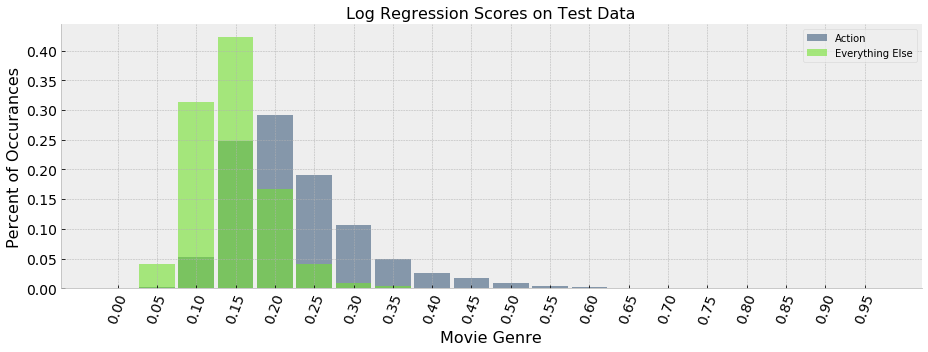

In [26]:
plt.figure(figsize=(13, 5))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

plt.xticks(np.arange(0, 1, .05), fontsize=14, rotation = 70)  
plt.yticks(fontsize=14)

plt.xlabel("Movie Genre", fontsize=16)  
plt.ylabel("Percent of Occurances", fontsize=16)
plt.title('Log Regression Scores on Test Data', fontsize=16)

bins = np.arange(0, 1.05, 0.05)
h_drama, be = np.histogram([d[0] for d in lr_genre_scores], bins)
h_comedy, be = np.histogram([d[0] for d in lr_not_genre_scores], bins)
plt.bar(be[:-1], 1.0 * h_drama / np.sum(h_drama), width=0.045, facecolor = "#3F5D7D", alpha=0.6 )
plt.bar(be[:-1], 1.0 * h_comedy / np.sum(h_comedy), width=0.045, facecolor = "#74e22f", alpha=0.6 )
plt.legend([GENRE, 'Everything Else'])
plt.tight_layout()
# plt.savefig('/Users/dfinkel/git_base/python/my_site/assets/images/histogram_comedy_not_drama_lr.png')

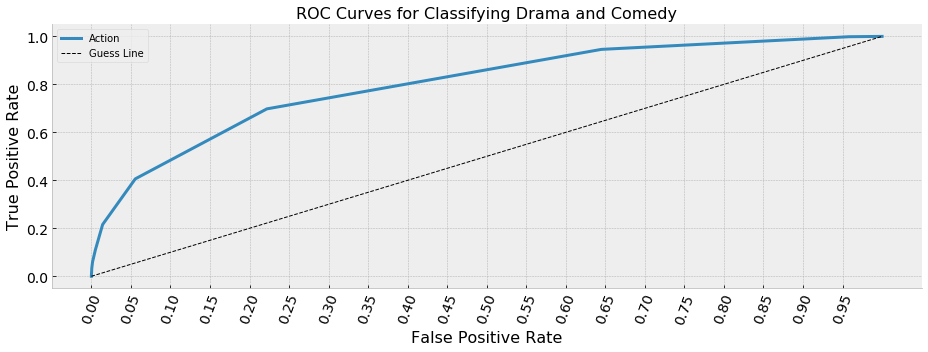

In [27]:
def roc_values(p1, p2):
    """
    compute true positive
    and false positive values
    relative to p1 and p2 vectors
    """
    tp = []
    fp = []
    for tt in np.arange(0, 1.05, 0.05):
        # tt is the threshold
        tp.append(1.0 * len([p for p in p1 if p[0] >= tt]) / len(p1))
        fp.append(1.0 * len([p for p in p2 if p[0] >= tt]) / len(p2))
        
    return tp, fp

genre_tp_lr, genre_fp_lr = roc_values(lr_genre_scores, lr_not_genre_scores)
# comedy_tp_lr, comedy_fp_lr = roc_values(1 - lr_comedy_scores, 1 - lr_drama_scores)

plt.figure(figsize=(13, 5))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

plt.xticks(np.arange(0, 1, .05), fontsize=14, rotation = 70)  
plt.yticks(fontsize=14)

plt.xlabel("False Positive Rate", fontsize=16)  
plt.ylabel("True Positive Rate", fontsize=16)
plt.title('ROC Curves for Classifying Drama and Comedy', fontsize=16)

plt.plot(genre_fp_lr, genre_tp_lr, linewidth=3)
plt.plot([0, 1], [0, 1], '--', color='k', linewidth=1)
# plt.plot(comedy_fp_dcnn, comedy_tp_dcnn, linewidth=3)
# plt.bar(be[:-1], 1.0 * h_comedy / np.sum(h_comedy), width=0.045, facecolor = "#74e22f", alpha=0.6 )
plt.legend([GENRE, 'Guess Line'])
plt.tight_layout()
# plt.savefig('/Users/dfinkel/git_base/python/my_site/assets/images/roc_comedy_not_comedy_lr.png')

In [37]:
def f1_finder(gs, ngs):
    f1 = []
    threshs = []
    precs = []
    recs = []
    for tt in np.arange(0, 1.02, .02):
        try:
            tp_ct = len([d for d in gs if d[0] >= tt])
            tn_ct = len([d for d in ngs if d[0] < tt])
            fp_ct = len([d for d in ngs if d[0] >= tt])

            precision = 1.0 * tp_ct / (tp_ct + fp_ct)
            recall = 1.0 * tp_ct / len(lr_genre_scores)
            f1.append(2. * precision * recall / (precision + recall))
            threshs.append(tt)
            precs.append(precision)
            recs.append(recall)
        except ZeroDivisionError:
            f1.append(0)
            precs.append(0)
            recs.append(0)
            threshs.append(tt)
    idx = np.argmax(f1)
    return threshs[idx], precs[idx], recs[idx], f1[idx]

lr_threshold, lr_precision, lr_recall, lr_f1 = f1_finder(lr_genre_scores, lr_not_genre_scores)
dcnn_threshold, dcnn_precision, dcnn_recall, dcnn_f1 = f1_finder(genre_probs, not_genre_probs)
print 'DCNN: Thresh: %.2f Prec: %.2f Rec: %.2f F1: %.2f' % (dcnn_threshold, dcnn_precision, dcnn_recall, dcnn_f1)
print 'LR: Thresh: %.2f Prec: %.2f Rec: %.2f F1: %.2f' % (lr_threshold, lr_precision, lr_recall, lr_f1)
# tp_ct = len([d for d in lr_genre_scores if d[0] >= 0.25])
# tn_ct = len([d for d in lr_not_genre_scores if d[0] < 0.25])
# fp_ct = len([d for d in lr_not_genre_scores if d[0] >= 0.25])
# print 1.0 * tp_ct / len(genre_probs), 1.0 * tn_ct / len(not_genre_probs), 1.0 * (tp_ct + tn_ct) / (len(genre_probs) + len(not_genre_probs))

# precision = 1.0 * tp_ct / (tp_ct + fp_ct)
# recall = 1.0 * tp_ct / len(lr_genre_scores)
# f1 = 2. * precision * recall / (precision + recall)
# print precision, recall, f1

DCNN: Thresh: 0.70 Prec: 0.48 Rec: 0.56 F1: 0.52
LR: Thresh: 0.22 Prec: 0.49 Rec: 0.58 F1: 0.53


In [61]:
lr_action = []
dcnn_action = []
for ii in np.arange(len(lr_genre_scores)):
    if lr_genre_scores[ii][0] >= lr_threshold:
        lr_action.append(1)
    else:
        lr_action.append(0)
    if genre_probs[ii][0] >= dcnn_threshold:
        dcnn_action.append(1)
    else:
        dcnn_action.append(0)
df_comparison = pd.DataFrame(data=zip(lr_action, dcnn_action), columns=(('LR', 'DCNN')))            
df_comparison.head()


print len(df_comparison), \
      len(df_comparison.loc[df_comparison['LR'] == 1].loc[df_comparison['DCNN'] == 1]), \
      len(df_comparison.loc[df_comparison['LR'] == 0].loc[df_comparison['DCNN'] == 1]), \
      len(df_comparison.loc[df_comparison['LR'] == 1].loc[df_comparison['DCNN'] == 0]), \
      len(df_comparison.loc[df_comparison['LR'] == 0].loc[df_comparison['DCNN'] == 0])        

lr_not_action = []
dcnn_not_action = []
for ii in np.arange(len(lr_not_genre_scores)):
    if lr_not_genre_scores[ii][0] <= lr_threshold:
        lr_not_action.append(1)
    else:
        lr_not_action.append(0)
    if not_genre_probs[ii][0] <= dcnn_threshold:
        dcnn_not_action.append(1)
    else:
        dcnn_not_action.append(0)
df_comparison_na = pd.DataFrame(data=zip(lr_not_action, dcnn_not_action), columns=(('LR', 'DCNN')))            
df_comparison_na.head()


print len(df_comparison_na), \
      len(df_comparison_na.loc[df_comparison_na['LR'] == 1].loc[df_comparison_na['DCNN'] == 1]), \
      len(df_comparison_na.loc[df_comparison_na['LR'] == 0].loc[df_comparison_na['DCNN'] == 1]), \
      len(df_comparison_na.loc[df_comparison_na['LR'] == 1].loc[df_comparison_na['DCNN'] == 0]), \
      len(df_comparison_na.loc[df_comparison_na['LR'] == 0].loc[df_comparison_na['DCNN'] == 0])

print df_test_genre.iloc[73]['title'], df_test_genre.iloc[73]['text']
df_comparison.head(100)

4302 1983 432 511 1376
20428 16509 1303 1325 1291
Shepherd (1998) If "B" movies, tired and corny scripts, and golf carts dressed up as some sort of futuristic mode of transport are your sort of entertainment, you'll probably enjoy this. Otherwise, forget it. The topless newsreader, though completely irrelevant, did give a few seconds of amusement.


,LR,DCNN
0,0,0
1,0,0
2,0,0
3,1,1
4,0,0
5,0,0
6,1,1
7,1,1
8,0,0
9,0,0


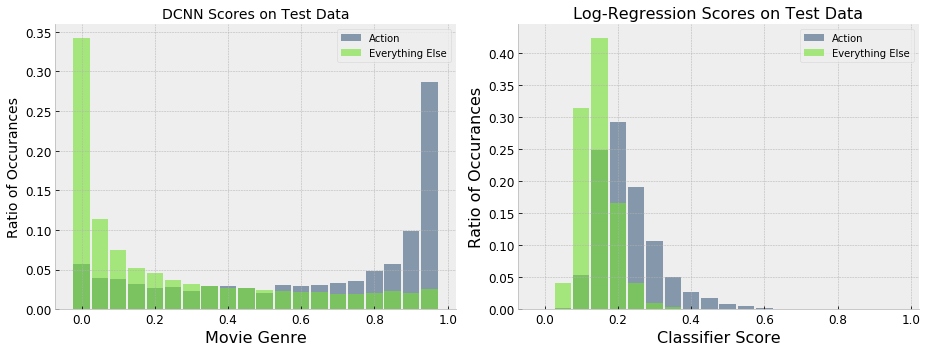

In [32]:
# plt.figure(figsize=(13, 5))
fig, ax = plt.subplots(1, 2, figsize=(13, 5))  
ax[0].spines["top"].set_visible(False)  
ax[0].spines["right"].set_visible(False)

ax[0].get_xaxis().tick_bottom()  
ax[0].get_yaxis().tick_left() 

# ax[0].set_xticks(np.arange(0, 1, .05), fontsize=14, rotation = 70)  
# ax[0].set_yticks(fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].tick_params(axis='both', which='minor', labelsize=12)

ax[0].set_xlabel("Movie Genre", fontsize=16)  
ax[0].set_ylabel("Ratio of Occurances", fontsize=14)
ax[0].set_title('DCNN Scores on Test Data', fontsize=14)

bins = np.arange(0, 1.05, 0.05)
h_drama, be = np.histogram([d[0] for d in genre_probs], bins)
h_comedy, be = np.histogram([d[0] for d in not_genre_probs], bins)
ax[0].bar(be[:-1], 1.0 * h_drama / np.sum(h_drama), width=0.045, facecolor = "#3F5D7D", alpha=0.6 )
ax[0].bar(be[:-1], 1.0 * h_comedy / np.sum(h_comedy), width=0.045, facecolor = "#74e22f", alpha=0.6 )
ax[0].legend(['Action', 'Everything Else'])

ax[1].spines["top"].set_visible(False)  
ax[1].spines["right"].set_visible(False)

ax[1].get_xaxis().tick_bottom()  
ax[1].get_yaxis().tick_left() 

# ax[0].set_xticks(np.arange(0, 1, .05), fontsize=14, rotation = 70)  
# ax[0].set_yticks(fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='minor', labelsize=12)

ax[1].set_xlabel("Classifier Score", fontsize=16)  
ax[1].set_ylabel("Ratio of Occurances", fontsize=16)
ax[1].set_title('Log-Regression Scores on Test Data', fontsize=16)

bins = np.arange(0, 1.05, 0.05)
h_drama, be = np.histogram([d[0] for d in lr_genre_scores], bins)
h_comedy, be = np.histogram([d[0] for d in lr_not_genre_scores], bins)
ax[1].bar(be[:-1], 1.0 * h_drama / np.sum(h_drama), width=0.045, facecolor = "#3F5D7D", alpha=0.6 )
ax[1].bar(be[:-1], 1.0 * h_comedy / np.sum(h_comedy), width=0.045, facecolor = "#74e22f", alpha=0.6 )
ax[1].legend(['Action', 'Everything Else'])

plt.tight_layout()
plt.savefig('/Users/dfinkel/git_base/python/my_site/assets/images/histogram_comparing_dcnn_logr.png')

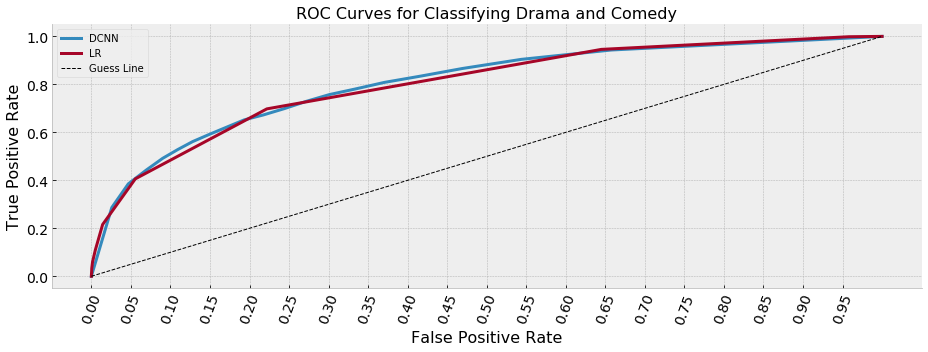

In [34]:
plt.figure(figsize=(13, 5))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

plt.xticks(np.arange(0, 1, .05), fontsize=14, rotation = 70)  
plt.yticks(fontsize=14)

plt.xlabel("False Positive Rate", fontsize=16)  
plt.ylabel("True Positive Rate", fontsize=16)
plt.title('ROC Curves for Classifying Drama and Comedy', fontsize=16)

plt.plot(genre_fp_dcnn, genre_tp_dcnn, linewidth=3)
plt.plot(genre_fp_lr, genre_tp_lr, linewidth=3)

plt.plot([0, 1], [0, 1], '--', color='k', linewidth=1)
# plt.plot(comedy_fp_dcnn, comedy_tp_dcnn, linewidth=3)
# plt.bar(be[:-1], 1.0 * h_comedy / np.sum(h_comedy), width=0.045, facecolor = "#74e22f", alpha=0.6 )
plt.legend(['DCNN', 'LR', 'Guess Line'])
plt.tight_layout()
plt.savefig('/Users/dfinkel/git_base/python/my_site/assets/images/both_roc_curves.png')

## Classify All Genres

Build a bank of binary LR classifiers for each unique genre in the training set

In [ ]:
roc_data = []
f1_scores = []
thresholds = []

genres = df_train.columns[4:-3].values
for genre in genres:
    print 'Starting %s' % genre
    
    # create labels
    df_train['class'] = 1 - df_train[genre].values

    X_ = df_train['text'].values
    Y_ = df_train['class'].values

    # Create classifier
    pipeline = Pipeline([
        ('vect', CountVectorizer(ngram_range=(1, 3))),
        ('tf_idf', TfidfTransformer()),
        ('clf', LogisticRegression(C=0.39810717055349731, class_weight=None)),])
    
    # Train Classifier
    pipeline.fit(X_, Y_)
    
    # Build Test sets
    df_test_genre = df_test.loc[df_test[genre] == 1]
    df_test_not_genre = df_test.loc[df_test[genre] == 0]
    
    # Predict scores for in/out of genre predictions
    X_ = df_test_genre['text'].values
    lr_genre_scores = pipeline.predict_proba(X_)

    X_ = df_test_not_genre['text'].values
    lr_not_genre_scores = pipeline.predict_proba(X_)
    
    # Compute ROC values
    genre_tp_lr, genre_fp_lr = roc_values(lr_genre_scores, lr_not_genre_scores)
    
    threshold, f1 = f1_finder(lr_genre_scores, lr_not_genre_scores)
    
    roc_data.append([genre_tp_lr, genre_fp_lr])
    f1_scores.append(f1)
    thresholds.append(threshold)
    
    print 'Through %s' % genre

In [ ]:
zip(genres, f1_scores)

In [ ]:
plt.figure(figsize=(13, 5))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

plt.xticks(np.arange(len(genres)), np.array(genres)[np.argsort(f1_scores)[::-1]], fontsize=14, rotation = 70)  
plt.yticks(fontsize=14)

plt.xlabel("Movie Genre", fontsize=16)  
plt.ylabel("F1 Score", fontsize=16)
plt.title('F1 Score of Log Regression Classifier for Movie Genre', fontsize=16)

plt.bar(np.arange(len(genres)), np.sort(f1_scores)[::-1], width=0.9, facecolor = "#3F5D7D", alpha=0.95)
plt.tight_layout()
plt.savefig('/Users/dfinkel/git_base/python/my_site/assets/images/histogram_f1_score_lr.png')

In [ ]:
plt.figure(figsize=(13, 5))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 

plt.xticks(np.arange(0, 1, .05), fontsize=14, rotation = 70)  
plt.yticks(fontsize=14)

plt.xlabel("False Positive Rate", fontsize=16)  
plt.ylabel("True Positive Rate", fontsize=16)
plt.title('ROC Curves for Classifying Drama and Comedy', fontsize=16)

for rd in roc_data:
    plt.plot(rd[1], rd[0], linewidth=2)

# plt.plot([0, 1], [0, 1], '--', color='k', linewidth=1)
plt.legend(genres, fontsize=6)
plt.tight_layout()
plt.savefig('/Users/dfinkel/git_base/python/my_site/assets/images/roc_all_genres_lr.png')

In [ ]:
df_train.head()